In [1]:
import itertools
from functools import partial

import geopandas as gpd
import numpy as np
import pandas as pd
import vsketch
from fn.fn import new_savepath
from geodude.intersection import (
    assign_psuedoperiodic_order_to_adjacent_clusters,
    assign_random_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons, find_adjacency_clusters,
    find_contained_polys, find_intersecting_polys, find_parent_polygons,
    find_touching_polys, merge_disjoint_polys, pairwise_partition_polygons)
from geodude.line import bezier_func, dash_linestring
from geodude.ops import buft_fill, make_like
from geodude.parameter import Prm, prms
from geodude.subdivide import (bino_draw, flex_rule_recursive_split,
                               random_line_subdivide,
                               split_along_longest_side_of_min_rectangle,
                               split_poly)
from geodude.utils import (Paper, flatten_geoms, merge_LineStrings,
                           merge_Polygons)
from matplotlib import pyplot as plt
from shapely import is_valid, unary_union
from shapely.geometry import (LineString, MultiLineString, MultiPoint,
                              MultiPolygon, Point, Polygon, box)
from shapely.ops import nearest_points

%load_ext autoreload
%autoreload 2

# try 1

In [2]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [4]:
phi = (1 + 5 ** 0.5) / 2
xgen = Prm(1/phi)

split_func = partial(split_along_longest_side_of_min_rectangle, xgen=xgen)

continue_func = partial(bino_draw, p_continue=0.85)
polys = flex_rule_recursive_split(poly=drawbox, split_func=split_func, continue_func=continue_func, depth=0, depth_limit=14)
gdf = gpd.GeoDataFrame(geometry=polys)

gdf.geometry = gdf.geometry.buffer(-1)
gdf = gdf[~gdf.geometry.is_empty]
gdf.boundary.plot()

In [82]:
drawbox.bounds

(30.0, 30.0, 249.39999999999998, 325.59999999999997)

In [6]:
effective_drawbox = box(*unary_union(gdf.geometry).bounds)

In [7]:
n_centers = 3
center_ys = np.linspace(100, 300, n_centers)
center_xs = np.linspace(60, 220, n_centers)
radii = np.random.uniform(75, 170, n_centers)
thickness = np.random.uniform(1, 7, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(effective_drawbox) for c, thickness in zip(circles, thickness)]

<Axes: >

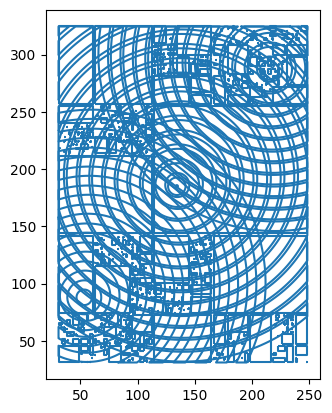

In [9]:
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -10))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(effective_drawbox) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, flatten_geoms(buffed_fills)]).explode(index_parts=False).reset_index(drop=True)
combined.boundary.plot()

In [10]:
disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    )

In [11]:
disjoint = find_parent_polygons(disjoint=disjoint, original=combined)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [12]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-2
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

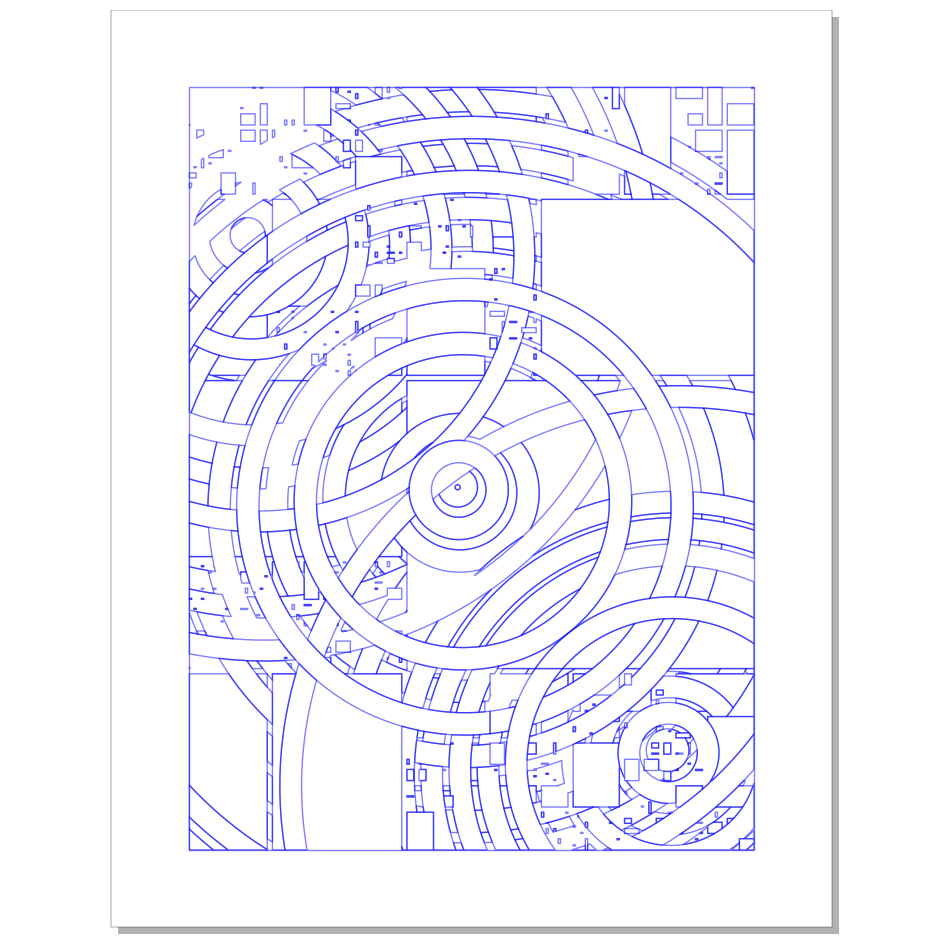

In [13]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.sample(frac=0.8, replace=False).geometry if p.boundary is not None]
mls = merge_LineStrings(lss + [effective_drawbox.boundary])


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))

In [14]:
sk.vpype('splitall linemerge linesort')

In [15]:
fp = new_savepath(postfix='circles_and_subdivides')
sk.save(fp)

# with fills

In [2]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

<Axes: >

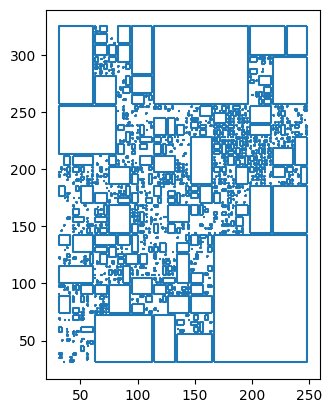

In [7]:
phi = (1 + 5 ** 0.5) / 2
xgen = Prm(1/phi)

split_func = partial(split_along_longest_side_of_min_rectangle, xgen=xgen)
continue_func = partial(bino_draw, p_continue=0.87)
polys = flex_rule_recursive_split(poly=drawbox, split_func=split_func, continue_func=continue_func, depth=0, depth_limit=14)
gdf = gpd.GeoDataFrame(geometry=polys)
gdf.geometry = gdf.geometry.buffer(-0.9, cap_style='square')
gdf = gdf[~gdf.geometry.is_empty]


gdf.boundary.plot()

<Axes: >

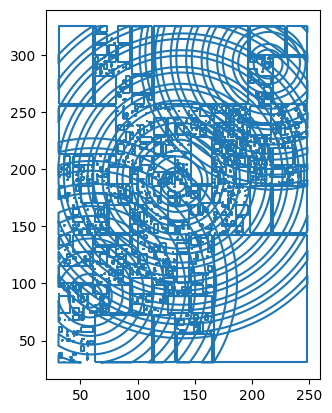

In [8]:
effective_drawbox = box(*unary_union(gdf.geometry).bounds)
n_centers = 3
center_ys = np.linspace(100, 300, n_centers)
center_xs = np.linspace(60, 220, n_centers)
radii = np.random.uniform(75, 270, n_centers)
thickness = np.random.uniform(1, 5, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(effective_drawbox) for c, thickness in zip(circles, thickness)]
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -10))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(effective_drawbox) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, flatten_geoms(buffed_fills).explode(index_parts=False)]).reset_index(drop=True)
combined.boundary.plot()

In [9]:
disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    )
disjoint = find_parent_polygons(disjoint=disjoint, original=combined)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-4
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

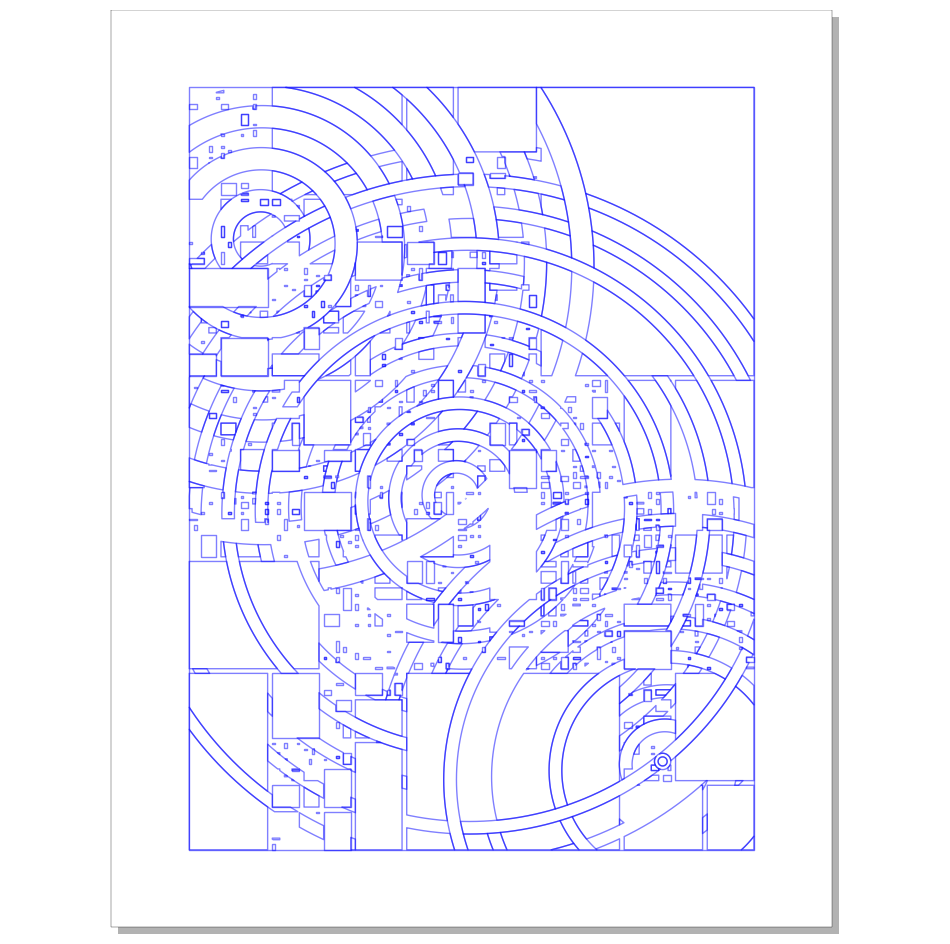

In [10]:
sampled_ngdf = ngdf.sample(frac=0.8, replace=False)

lss = [p.boundary for p in sampled_ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss + [effective_drawbox.boundary])


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))

In [11]:
fills = []
for geom in combined.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.1))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.4, 0.9))
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary)
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [12]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))
    masked.append(mask.boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

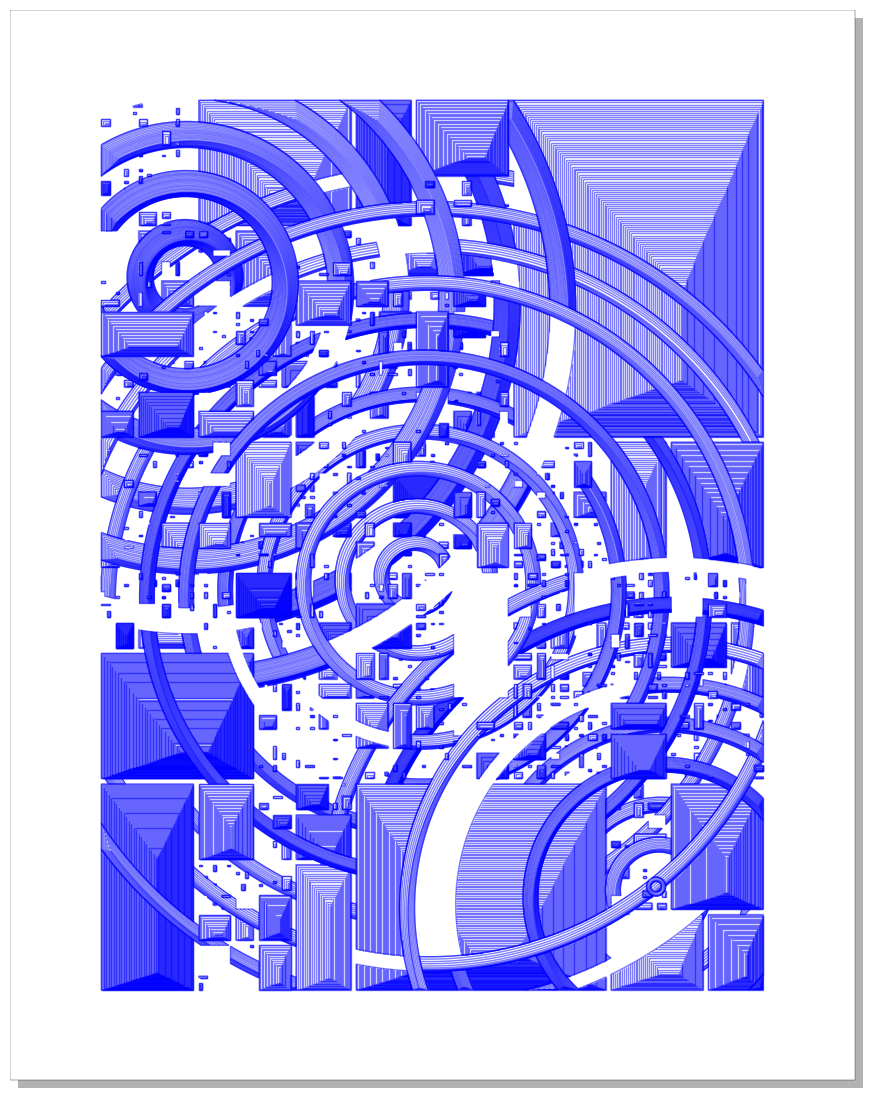

In [13]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display(fig_size=(11, 14))

In [16]:
# more circles
n_centers = 2
center_ys = np.linspace(100, 300, n_centers)
center_xs = np.linspace(220, 60, n_centers)
radii = np.random.uniform(75, 270, n_centers)
thickness = np.random.uniform(0.5, 3, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(effective_drawbox) for c, thickness in zip(circles, thickness)]
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-15, -5))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(effective_drawbox) for f, t in zip(fills, thickness)]
background_circles = flatten_geoms(buffed_fills).explode(index_parts=False)

In [18]:
fills = []
for geom in background_circles.geometry:
    d_buffer = Prm(np.random.uniform(-0.9, -0.3))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.3, 0.9))
    deg = Prm(np.random.uniform(70, 110))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary)
bg_fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [19]:
disjoint = chunked_pairwise_partition_polygons(
    background_circles, 
    chunk_size=10,
    min_area=1e-3,
    verbose=True,
    )

Iteration 1
Finding intersections in 42 polygons
146 intersections remaining
Chunking polygons
Partitioning 3 chunks


3it [00:00,  6.66it/s]


Iteration 1 complete, 232 polygons remaining
Iteration 2
Finding intersections in 232 polygons
106 intersections remaining
Chunking polygons
Partitioning 5 chunks


5it [00:00, 17.02it/s]


Iteration 2 complete, 157 polygons remaining
Iteration 3
Finding intersections in 157 polygons
32 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 19.12it/s]


Iteration 3 complete, 60 polygons remaining
Iteration 4
Finding intersections in 60 polygons
4 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 56.04it/s]


Iteration 4 complete, 10 polygons remaining
Iteration 5
Finding intersections in 10 polygons
0 intersections remaining
Chunking polygons


In [20]:
disjoint = find_parent_polygons(disjoint=disjoint, original=background_circles)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)
bgngdf = merge_disjoint_polys(disjoint)
bgngdf = bgngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-4
bgngdf.geometry = bgngdf.buffer(buffer_value).buffer(-buffer_value)
bgngdf.geometry = bgngdf.buffer(-buffer_value).buffer(buffer_value)
bgngdf = bgngdf.explode(index_parts=False).reset_index(drop=True)
bgngdf['area'] =bgngdf.area
idx = (bgngdf.area > 1e-9) & ~bgngdf.is_empty
idx = idx & (bgngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
bgngdf = bgngdf[idx]

In [21]:
unary_union(sampled_ngdf.geometry.values)

,parent,geometry,area
376,429,"POLYGON ((97.807 250.426, 97.806 250.426, 97.8...",1.731903
644,723,"POLYGON ((230.517 230.064, 230.517 230.064, 23...",0.655507
899,904,"POLYGON ((112.903 295.965, 112.903 295.965, 11...",8.951767
710,798,"POLYGON ((161.827 143.809, 161.827 143.809, 16...",0.655507
499,547,"POLYGON ((215.404 224.375, 215.404 224.375, 21...",0.655508
...,...,...,...
888,903,"POLYGON ((211.577 290.665, 211.577 290.665, 21...",9.514999
262,291,"POLYGON ((50.683 190.825, 50.683 190.825, 50.6...",5.995265
829,891,"POLYGON ((30.900 161.907, 30.900 161.907, 30.9...",56.576079
193,215,"POLYGON ((134.487 30.900, 134.487 30.900, 134....",715.552639


In [27]:
background_circles_occluded = bgngdf.difference(unary_union(sampled_ngdf.geometry.values)).dropna().explode(index_parts=False).reset_index(drop=True)

In [24]:
idx = ~background_circles_occluded.is_empty
background_circles_occluded = background_circles_occluded[idx]

In [28]:
masked = []

for ii, row in bg_fill_gdf.iterrows():
    fill = row.geometry
    mask = bgngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))
    masked.append(mask.boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
bg_mls = merge_LineStrings(masked.to_list())

In [1]:
merged_mls = merge_LineStrings([fill_mls, bg_mls])

NameError: name 'merge_LineStrings' is not defined

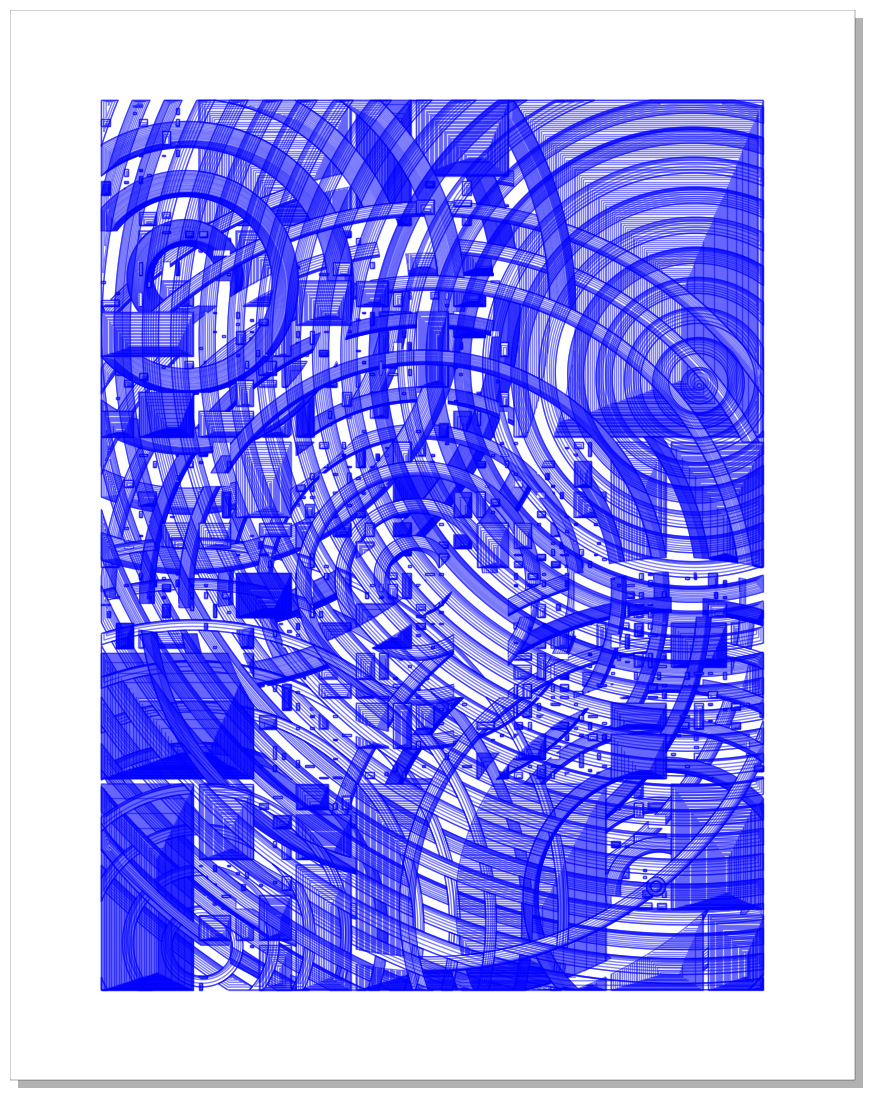

In [30]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(merged_mls, drawbox))
sk.display(fig_size=(11, 14))

In [14]:
sk.vpype('linesort')

In [15]:
fp = new_savepath(postfix='circles_and_subdivides_filled')
sk.save(fp)